## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [1]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random

import sinogap_module_alt_0 as sg




### <font style="color:lightblue">Redefine</font>

In [2]:
sg.plt.rcParams['figure.dpi']=223





### <font style="color:lightblue">Configs</font>

In [3]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 1
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize = 2**6
    ,batchSplit = 1
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateD = 0.00005
    ,learningRateG = 0.00005
)

sg.DCfg = sg.DCfgClass(16)


### <font style="color:lightblue">Raw Read</font>

In [ ]:
trainSet = sg.createTrainSet()
testSet = sg.createTestSet()

### <font style="color:lightblue">Show</font>

In [ ]:
sg.refImages, sg.refNoises = sg.createReferences(testSet, 0)
sg.showMe(testSet, 0 )

## <font style="color:lightblue">Models</font>

### Generator 2pix

In [ ]:


class Generator2(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator2, self).__init__(2)
        self.encoders =  nn.ModuleList([
            self.encblock(  1/self.baseChannels,
                               1, 3, norm=False),
            self.encblock(  1, 1, 3),
            self.encblock(  1, 1, 3),
            ])
        self.fcLink = self.createFClink()
        self.decoders = nn.ModuleList([
            self.decblock(2, 1, 3),
            self.decblock(2, 1, 3),
            self.decblock(2, 1, 3, norm=False),
            ])
        self.lastTouch = self.createLastTouch()
        sg.load_model(self, model_path="saves/gap2/noBNreNorm/model_gen.pt" )

generator2 = Generator2()
generator2 = generator2.to(sg.TCfg.device)
generator2 = generator2.requires_grad_(False)
generator2 = generator2.eval()
sg.lowResGenerators[2] = generator2



### Generator 4pix

In [10]:


class Generator4(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator4, self).__init__(4)
        self.encoders =  nn.ModuleList([
            self.encblock( 1/self.baseChannels,
                              1, 3, norm=False),
            self.encblock( 1, 1, 3),
            self.encblock( 1, 2, 3, stride=2),
            self.encblock( 2, 2, 3),
            self.encblock( 2, 4, 3),
            ])
        self.fcLink = self.createFClink()
        self.decoders = nn.ModuleList([
            self.decblock(8, 2, 3),
            self.decblock(4, 2, 3),
            self.decblock(4, 1, 4, stride=2),
            self.decblock(2, 1, 3),
            self.decblock(2, 1, 3, norm=False),
            ])
        self.lastTouch = self.createLastTouch()
        sg.load_model(self, model_path="saves/gap4/noBNreNorm/model_gen.pt" )

generator4 = Generator4()
generator4 = generator4.to(sg.TCfg.device)
generator4 = generator4.requires_grad_(False)
generator4 = generator4.eval()
sg.lowResGenerators[4] = generator4





### Generator 8pix

In [11]:


class Generator8(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator8, self).__init__(8)

        self.encoders =  nn.ModuleList([
            self.encblock( 1/self.baseChannels,
                              1, 3, norm=False),
            self.encblock( 1, 1, 3, dopadding=True),
            self.encblock( 1, 2, 3, stride=2),
            self.encblock( 2, 2, 3, dopadding=True),
            self.encblock( 2, 4, 3, stride=2),
            self.encblock( 4, 4, 3, dopadding=True),
            self.encblock( 4, 8, 3, stride=2),
            self.encblock( 8, 8, 3, dopadding=True),
            ])

        self.fcLink = self.createFClink()

        self.decoders = nn.ModuleList([
            self.decblock(16, 8, 3, dopadding=True),
            self.decblock(16, 4, 4, stride=2),
            self.decblock( 8, 4, 3, dopadding=True),
            self.decblock( 8, 2, 4, stride=2),
            self.decblock( 4, 2, 3, dopadding=True),
            self.decblock( 4, 1, 4, stride=2),
            self.decblock( 2, 1, 3, dopadding=True),
            self.decblock( 2, 1, 3, norm=False),
            ])

        self.lastTouch = self.createLastTouch()
        sg.load_model(self, model_path="model_3_gen.pt" )


generator8 = Generator8()
generator8 = generator8.to(sg.TCfg.device)
generator8 = generator8.requires_grad_(False)
generator8 = generator8.eval()
sg.lowResGenerators[8] = generator8

### Generator 16pix

In [12]:


class Generator16(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator16, self).__init__(16,1)

        self.noise2latent = self.createLatent()

        self.encoders =  nn.ModuleList([
            self.encblock( (1+self.latentChannels) /self.baseChannels,
                               1, 3, norm=False),
            self.encblock( 1,  1, 3, dopadding=True),
            self.encblock( 1,  2, 3, stride=2),
            self.encblock( 2,  2, 3, dopadding=True),
            self.encblock( 2,  4, 3, stride=2),
            self.encblock( 4,  4, 3, dopadding=True),
            self.encblock( 4,  8, 3, stride=2),
            self.encblock( 8,  8, 3, dopadding=True),
            self.encblock( 8, 16, 3, stride=2),
            self.encblock(16, 16, 3, dopadding=True),
            ])

        self.fcLink = self.createFClink()

        self.decoders = nn.ModuleList([
            self.decblock(32, 16, 3, dopadding=True),
            self.decblock(32,  8, 4, stride=2),
            self.decblock(16,  8, 3, dopadding=True),
            self.decblock(16,  4, 4, stride=2),
            self.decblock( 8,  4, 3, dopadding=True),
            self.decblock( 8,  2, 4, stride=2),
            self.decblock( 4,  2, 3, dopadding=True),
            self.decblock( 4,  1, 4, stride=2),
            self.decblock( 2,  1, 3, dopadding=True),
            self.decblock( 2,  1, 3, norm=False),
            ])

        self.lastTouch = self.createLastTouch()
        sg.load_model(self, model_path="/data/anton/sinogap/tmp/model_noBN_gap16_starter.pt" )

generator16 = Generator16()
generator16 = generator16.to(sg.TCfg.device)
sg.lowResGenerators[16] = generator16




### <font style="color:lightblue">Generator</font>

In [13]:
sg.generator = sg.lowResGenerators[sg.DCfg.gapW]
sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG)
model_summary = summary(sg.generator, input_data=[ [sg.refImages[[0],...], sg.refNoises[[0],...]] ] ).__str__()
print(model_summary)


Layer (type:depth-idx)                   Output Shape              Param #
Generator16                              [1, 1, 80, 16]            --
├─Sequential: 1-1                        [1, 1, 80, 80]            --
│    └─Linear: 2-1                       [1, 6400]                 416,000
│    └─ReLU: 2-2                         [1, 6400]                 --
│    └─Unflatten: 2-3                    [1, 1, 80, 80]            --
├─ModuleList: 1-2                        --                        --
│    └─Sequential: 2-4                   [1, 64, 78, 78]           --
│    │    └─Conv2d: 3-1                  [1, 64, 78, 78]           1,216
│    │    └─LeakyReLU: 3-2               [1, 64, 78, 78]           --
│    └─Sequential: 2-5                   [1, 64, 78, 78]           --
│    │    └─Conv2d: 3-3                  [1, 64, 78, 78]           36,928
│    │    └─LeakyReLU: 3-4               [1, 64, 78, 78]           --
│    └─Sequential: 2-6                   [1, 128, 38, 38]          --
│  

### <font style="color:lightblue">Discriminator</font>

In [14]:

class Discriminator(sg.DiscriminatorTemplate):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.param = nn.Parameter(torch.zeros(1))
    def forward(self, images):
        return torch.zeros((images.shape[0],1), device=sg.TCfg.device)


sg.discriminator = Discriminator()
sg.discriminator = sg.discriminator.to(sg.TCfg.device)
model_summary = summary(sg.discriminator, input_data=sg.refImages[0,...] ).__str__()
#print(model_summary)
#sg.writer.add_graph(sg.discriminator, refImages)

sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD)



## <font style="color:lightblue">Restore checkpoint</font>

Probabilities of reference images: Ref: 0.000e+00, Gen: 0.000e+00, Pre: 0.000e+00.
Distances of reference images: REC: 1.021e-03, MSE: 7.455e-04, L1L: 1.774e-02.


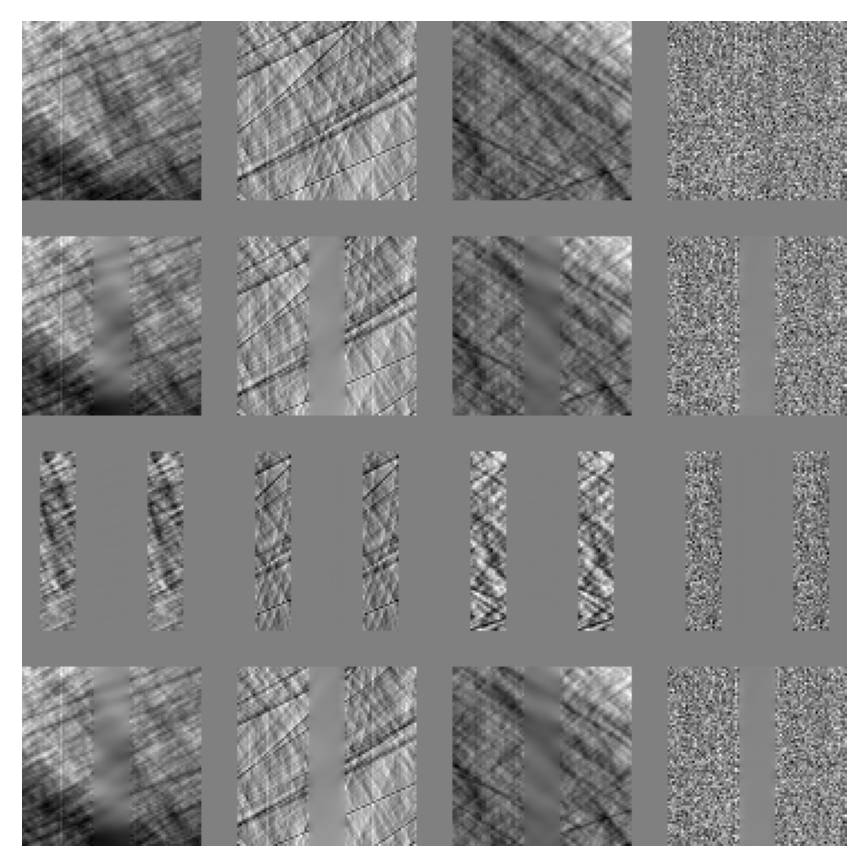

In [15]:
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom, sg.resAcc = \
    sg.restoreCheckpoint()#savedCheckPoint+".pth")
sg.writer = sg.createWriter(sg.TCfg.logDir, True)
#sg.writer.add_graph(sg.generator, ((sg.refImages, sg.refNoises),) )
#sg.writer.add_graph(sg.discriminator, refImages)
#sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom = 0, 0, 0, 1, 0
sg.initialTest()

In [17]:
#print("amplitude: ", sg.generator.amplitude.item(), 2 * torch.sigmoid(sg.generator.amplitude).item() )
#sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom = 0, 0, 0, 1, 0
#print(f"{sg.normRec.item():e}, {sg.normMSE.item():e}, {sg.normL1L.item():e}")
#print(f"{sg.normTestRec.item():e}, {sg.normTestMSE.item():e}, {sg.normTestL1L.item():e}")

## <font style="color:lightblue">Execute</font>

Epoch: 2 (1).  L1L: 0.971  MSE: 0.403  Rec: 0.978 (Train: 0.948, Test: 0.977 | 0.977).
TT: 0.00,  FT: 0.00,  HD: 8.638e+00,  GP: 0.000, 0.000 
TF: 0.00,  FF: 0.00,  LD: 7.562e-03,  R : 0.000.


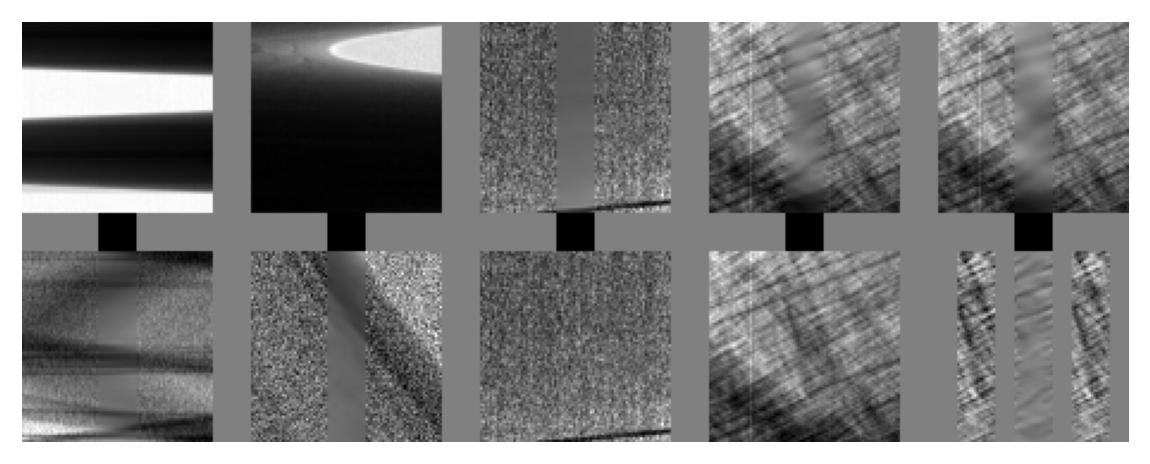

 98%|█████████▊| 135036/137323 [9:29:46<09:52,  3.86it/s]

In [ ]:
sg.noAdv = True
sg.dataLoader = sg.createDataLoader(trainSet, num_workers=16)
sg.testLoader = sg.createDataLoader(testSet , num_workers=16)
#sg.normRec, sg.normMSE, sg.normL1L = 1.031e-03,  1.630e-03, 1.070e-02
#sg.normTestRec, sg.normTestMSE, sg.normTestL1L =  7.210e-04, 2.623e-04, 5.942e-03
if sg.epoch == 0 :
    if sg.normRec == 1:
        sg.normRec, sg.normMSE, sg.normL1L, _ , _ = sg.summarizeSet(sg.dataLoader)
        sg.normTestRec, sg.normTestMSE, sg.normTestL1L, _ , _ = sg.summarizeSet(sg.testLoader)
    #sg.minGdLoss = sg.normTestRec
    #with torch.no_grad(): sg.generator.amplitude[()] = -math.log(1+2/sg.normMSE)

#torch.autograd.set_detect_anomaly(True)


#minGdLossToKeep = sg.minGdLoss
#startingEpoch=sg.epoch
#def my_afterEachEpoch(epoch) :
#    global startingEpoch, minGdLossToKeep
#    if sg.minGEpoch < startingEpoch+2 and sg.minGdLoss < minGdLossToKeep :
#        sg.minGdLoss = minGdLossToKeep
#        return
#    for item in itertools.chain( sg.optimizer_D.param_groups, sg.optimizer_G.param_groups ):
#        item['lr'] *= 0.99
#sg.afterEachEpoch = my_afterEachEpoch

#
#def my_afterEachEpoch(epoch) :
#    if sg.minGEpoch < 600 :
#        return
#    if not sg.dataLoader is None :
#        del sg.dataLoader
#        sg.freeGPUmem()
#    if sg.TCfg.batchSize < 131072 :
#    sg.TCfg.batchSize += round( 0.01 * sg.TCfg.batchSize )
#    sg.dataLoader = sg.createTrainLoader(trainSet, num_workers=24)
#    print("Batch size: ",sg.TCfg.batchSize)
#sg.afterEachEpoch = my_afterEachEpoch

def my_beforeReport() :
    return
    print("amplitude: ", sg.generator.amplitude.item() )
sg.beforeReport = my_beforeReport

sg.noAdv = True

try :
    sg.train(savedCheckPoint)
except :
    del sg.dataLoader
    del sg.testLoader
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    print(sg.normRec, sg.normMSE, sg.normL1L)
    print(sg.normTestRec, sg.normTestMSE, sg.normTestL1L)
    sg.epoch -= 1
    raise




## <font style="color:lightblue">Post</font>

In [ ]:
print (sg.generator.amplitude.item(), 2 * torch.sigmoid(sg.generator.amplitude).item() )
sg.initialTest()


In [ ]:
sg.testMe(trainSet, 5)

### <font style="color:lightblue">Save results</font>

In [ ]:
sg.saveModels()